___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://blog.ekinox.io/images/xgboost_lgbm_catboost.svg" width="350px" height="180px" />


# <font color= #8A0829> Laboratorio de Modelado de Datos </font>
#### <font color= #2E9AFE> `Martes y Viernes (Videoconferencia) de 13:00 - 15:00 hrs`</font>
- <Strong> Sara Eugenia Rodríguez </Strong>
- <Strong> Año </Strong>: 2025
- <Strong> Email: </Strong>  <font color="blue"> `sara.rodriguezr@iteso.mx` </font>
___

<p style="text-align:right;"> Imagen recuperada de: https://blog.ekinox.io/images/xgboost_lgbm_catboost.svg</p>

### <font color= #2E9AFE> Tema: Catboost vs XGBoost vs LightGBM</font>

## Los Datos (IBM HR)

Se busca descubrir los factores que conducen al desgaste de los empleados. Este es un conjunto de datos ficticio creado por científicos de datos de IBM.

Variables:
- Age
- Attrition (target)
- BusinessTravel
- DailyRate
- Department
- DistanceFromHome
- Education
- EducationField
- EnvironmentSatisfaction
- Gender
- HourlyRate
- JobInvolvement
- JobLevel
- JobRole
- JobSatisfaction
- MaritalStatus
- MonthlyIncome
- MonthlyRate
- NumCompaniesWorked
- OverTime
- PercentSalaryHike
- PerformanceRating
- RelationshipSatisfaction
- StockOptionLevel
- TotalWorkingYears
- TrainingTimesLastYear
- WorkLifeBalance
- YearsAtCompany
- YearsInCurrentRole
- YearsSinceLastPromotion
- YearsWithCurrManager

In [80]:
#pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [12]:
import time
import math
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sci
import plotly.offline as py
import plotly.graph_objs as go

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from hyperopt import hp, tpe, Trials, STATUS_OK
from hyperopt import fmin

from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

In [14]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")

In [16]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [20]:
df.nunique()

Age                           43
Attrition                      2
BusinessTravel                 3
DailyRate                    886
Department                     3
DistanceFromHome              29
Education                      5
EducationField                 6
EmployeeCount                  1
EmployeeNumber              1470
EnvironmentSatisfaction        4
Gender                         2
HourlyRate                    71
JobInvolvement                 4
JobLevel                       5
JobRole                        9
JobSatisfaction                4
MaritalStatus                  3
MonthlyIncome               1349
MonthlyRate                 1427
NumCompaniesWorked            10
Over18                         1
OverTime                       2
PercentSalaryHike             15
PerformanceRating              2
RelationshipSatisfaction       4
StandardHours                  1
StockOptionLevel               4
TotalWorkingYears             40
TrainingTimesLastYear          7
WorkLifeBa

In [88]:
#quitamos algunas variables
df.drop(columns = ["EmployeeCount", "Over18", "StandardHours"], inplace= True)

In [90]:
description = pd.DataFrame(index=['observations(rows)', 'percent missing', 'dtype', 'range'])
numerical = []
categorical = []
for col in df.columns:
    obs = df[col].size
    p_nan = round(df[col].isna().sum()/obs, 2)
    num_nan = f'{p_nan}% ({df[col].isna().sum()}/{obs})'
    dtype = 'categorical' if df[col].dtype == object else 'numerical'
    numerical.append(col) if dtype == 'numerical' else categorical.append(col)
    rng = f'{len(df[col].unique())} labels' if dtype == 'categorical' else f'{df[col].min()}-{df[col].max()}'
    description[col] = [obs, num_nan, dtype, rng]

pd.set_option('display.max_columns', 100)
display(description)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
observations(rows),1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
percent missing,0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470),0.0% (0/1470)
dtype,numerical,categorical,categorical,numerical,categorical,numerical,numerical,categorical,numerical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,categorical,numerical,numerical,numerical,categorical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical,numerical
range,18-60,2 labels,3 labels,102-1499,3 labels,1-29,1-5,6 labels,1-2068,1-4,2 labels,30-100,1-4,1-5,9 labels,1-4,3 labels,1009-19999,2094-26999,0-9,2 labels,11-25,3-4,1-4,0-3,0-40,0-6,1-4,0-40,0-18,0-15,0-17


**Qué vamos a observar?**

- Valores atípicos o inconsistencias en las columnas de datos
- ¿Tenemos un desbalanceo en la etiqueta objetivo?
- Cómo se distribuyen nuestras variables independientes en relación con nuestra etiqueta objetivo
- ¿Hay características que tienen fuertes relaciones lineales o monótonas?

## EDA

In [94]:
import hvplot.pandas

In [96]:
#Distancia de casa vs target
df.hvplot.hist(y='DistanceFromHome', by='Attrition', subplots=False, width=600, height=300, bins=10)

:NdOverlay   [Attrition]
   :Histogram   [DistanceFromHome]   (Count)

In [98]:
# Educacion vs target
df.hvplot.hist(y='Education', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [Education]   (Count)

In [100]:
#Satisfaccion con companieros vs target
df.hvplot.hist(y='RelationshipSatisfaction', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [RelationshipSatisfaction]   (Count)

In [102]:
#Satisfaccion en la oficina vs target
df.hvplot.hist(y='EnvironmentSatisfaction', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [EnvironmentSatisfaction]   (Count)

In [104]:
#Involucramiento laboral vs target
df.hvplot.hist(y='JobInvolvement', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [JobInvolvement]   (Count)

In [106]:
#Seniority vs target
df.hvplot.hist(y='JobLevel', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [JobLevel]   (Count)

In [108]:
#Satisfaccion laboral vs target
df.hvplot.hist(y='JobSatisfaction', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [JobSatisfaction]   (Count)

In [110]:
# num companias trabajadas vs target
df.hvplot.hist(y='NumCompaniesWorked', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [NumCompaniesWorked]   (Count)

In [112]:
#Aumento salarial vs target
df.hvplot.hist(y='PercentSalaryHike', by='Attrition', subplots=False, width=600, height=300)


:NdOverlay   [Attrition]
   :Histogram   [PercentSalaryHike]   (Count)

In [114]:
#acciones en la empresa vs target
df.hvplot.hist(y='StockOptionLevel', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [StockOptionLevel]   (Count)

In [116]:
#Trainings en el anio
df.hvplot.hist(y='TrainingTimesLastYear', by='Attrition', subplots=False, width=600, height=300)

:NdOverlay   [Attrition]
   :Histogram   [TrainingTimesLastYear]   (Count)

Parece que las características EnvironmentSatisfaction, JobSatisfaction, PerformanceRating y RelationshipSatisfaction no tienen un gran impacto en el target

In [119]:
#edad vs target
df.hvplot.hist(y='Age', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [Age]   (Count)

In [121]:
#salario mensual vs target
df.hvplot.hist(y='MonthlyIncome', by='Attrition', subplots=False, width=600, height=300, bins=50)

:NdOverlay   [Attrition]
   :Histogram   [MonthlyIncome]   (Count)

In [123]:
#anios en la compania
df.hvplot.hist(y='YearsAtCompany', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [YearsAtCompany]   (Count)

In [125]:
#Anios totales trabajados
df.hvplot.hist(y='TotalWorkingYears', by='Attrition', subplots=False, width=600, height=300, bins=35)

:NdOverlay   [Attrition]
   :Histogram   [TotalWorkingYears]   (Count)

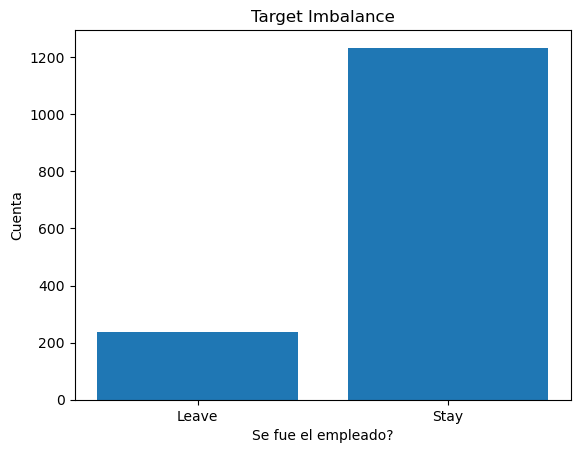

In [127]:
count_yes = df.Attrition[df.Attrition == 'Yes'].size
count_no = df.Attrition[df.Attrition == 'No'].size

plt.bar(['Leave', 'Stay'], [count_yes, count_no])
plt.title('Target Imbalance')
plt.xlabel('Se fue el empleado?')
plt.ylabel('Cuenta')
plt.show()

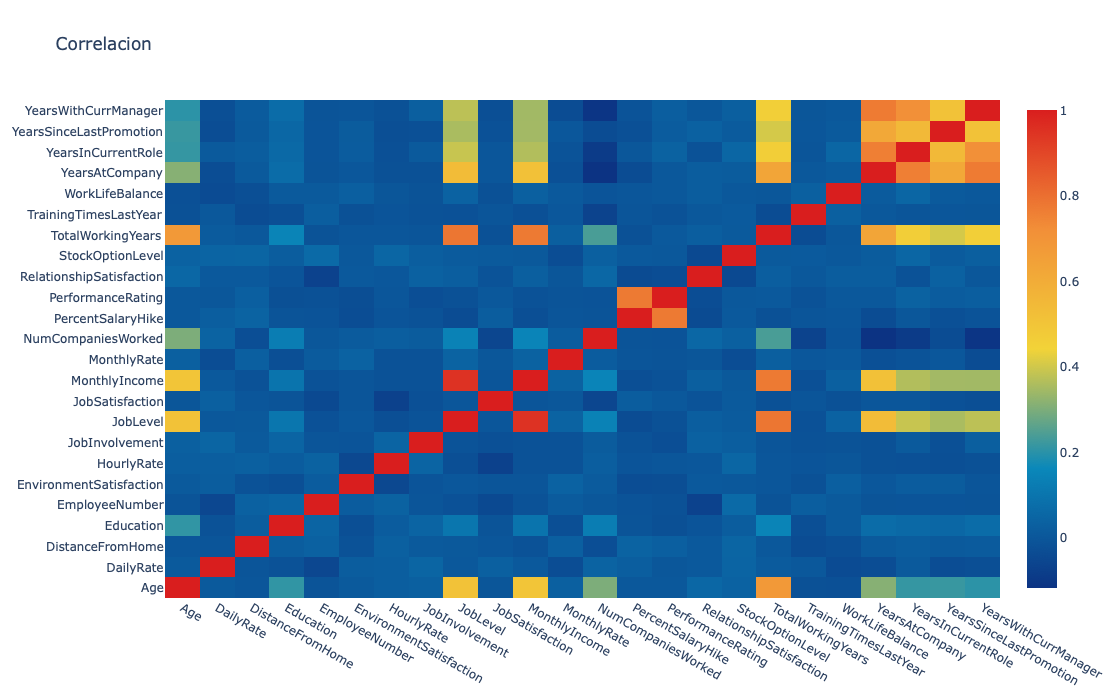

In [131]:
trace1 = go.Heatmap(
    z = df[numerical].astype(float).corr().values,
    x = df[numerical].columns.values,
    y = df[numerical].columns.values,
    colorscale = 'Portland', 
    reversescale = False, 
    opacity = 1.0)
        
data = [trace1]
layout = go.Layout(
    title = 'Correlacion',
    xaxis = dict(ticks = '', nticks = 36),
    yaxis = dict(ticks = ''),
    width = 700, height = 700
)

fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

## XGBoost

In [134]:
def org_results(trials, hyperparams, model_name):
    fit_idx = -1
    for idx, fit  in enumerate(trials):
        hyp = fit['misc']['vals']
        xgb_hyp = {key:[val] for key, val in hyperparams.items()}
        if hyp == xgb_hyp:
            fit_idx = idx
            break
            
    train_time = str(trials[-1]['refresh_time'] - trials[0]['book_time'])
    acc = round(trials[fit_idx]['result']['accuracy'], 3)
    train_auc = round(trials[fit_idx]['result']['train auc'], 3)
    test_auc = round(trials[fit_idx]['result']['test auc'], 3)

    results = {
        'model': model_name,
        'parameter search time': train_time,
        'accuracy': acc,
        'test auc score': test_auc,
        'training auc score': train_auc,
        'parameters': hyperparams
    }
    return results

In [136]:
xgb_data = df.copy()
xgb_dummy = pd.get_dummies(xgb_data[categorical], drop_first=True)
xgb_data = pd.concat([xgb_dummy, xgb_data], axis=1)
xgb_data.drop(columns = categorical, inplace=True)
xgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)

y_df = xgb_data['Attrition'].reset_index(drop=True)
x_df = xgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def xgb_objective(space, early_stopping_rounds=50):
    
    model = XGBClassifier(
        learning_rate = space['learning_rate'], 
        n_estimators = int(space['n_estimators']), 
        max_depth = int(space['max_depth']), 
        min_child_weight = space['m_child_weight'], 
        gamma = space['gamma'], 
        subsample = space['subsample'], 
        colsample_bytree = space['colsample_bytree'],
        objective = 'binary:logistic',
        eval_metric = 'auc',
        early_stopping_rounds = early_stopping_rounds  # Move here
    )
    
    model.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              verbose = False)
     
    predictions = model.predict(test_x)
    test_preds = model.predict_proba(test_x)[:,1]
    train_preds = model.predict_proba(train_x)[:,1]
    
    xgb_booster = model.get_booster()
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions) 
    
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 25),
    'max_depth': hp.quniform('max_depth', 1, 12, 1),
    'm_child_weight': hp.quniform('m_child_weight', 1, 6, 1),
    'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'learning_rate': hp.loguniform('learning_rate', np.log(.001), np.log(.3)),
    'colsample_bytree': hp.quniform('colsample_bytree', .5, 1, .1)
}

trials = Trials()
xgb_hyperparams = fmin(fn = xgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

xgb_results = org_results(trials.trials, xgb_hyperparams, 'XGBoost')
display(xgb_results)

100%|██████| 150/150 [00:17<00:00,  8.63trial/s, best loss: 0.12339728140364403]


{'model': 'XGBoost',
 'parameter search time': '0:00:17.383000',
 'accuracy': 0.891,
 'test auc score': 0.877,
 'training auc score': 0.87,
 'parameters': {'colsample_bytree': 0.9,
  'gamma': 1.0,
  'learning_rate': 0.29999035590045914,
  'm_child_weight': 4.0,
  'max_depth': 1.0,
  'n_estimators': 950.0,
  'subsample': 0.65}}

## LightGBM

In [138]:
from lightgbm import early_stopping

lgb_data = df.copy()
lgb_dummy = pd.get_dummies(lgb_data[categorical], drop_first=True)
lgb_data = pd.concat([lgb_dummy, lgb_data], axis=1)
lgb_data.drop(columns = categorical, inplace=True)
lgb_data.rename(columns={'Attrition_Yes': 'Attrition'}, inplace=True)
y_df = lgb_data['Attrition'].reset_index(drop=True)
x_df = lgb_data.drop(columns='Attrition')
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)

def lgb_objective(space, early_stopping_rounds=50):
    
    lgbm = LGBMClassifier(
        learning_rate = space['learning_rate'],
        n_estimators= int(space['n_estimators']), 
        max_depth = int(space['max_depth']),
        num_leaves = int(space['num_leaves']),
        colsample_bytree = space['colsample_bytree'],
        feature_fraction = space['feature_fraction'],
        reg_lambda = space['reg_lambda'],
        reg_alpha = space['reg_alpha'],
        min_split_gain = space['min_split_gain'],
        verbose = -1
    )
    
    lgbm.fit(train_x, train_y, 
            eval_set = [(train_x, train_y), (test_x, test_y)],
            eval_metric = 'auc',
            callbacks = [early_stopping(stopping_rounds=early_stopping_rounds, verbose=False)])
    
    predictions = lgbm.predict(test_x)
    test_preds = lgbm.predict_proba(test_x)[:,1]
    train_preds = lgbm.predict_proba(train_x)[:,1]
    
    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)  
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc
           }

trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.3)),
    'n_estimators': hp.quniform('n_estimators', 50, 1200, 25),
    'max_depth': hp.quniform('max_depth', 1, 15, 1),
    'num_leaves': hp.quniform('num_leaves', 10, 150, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0), 
    'feature_fraction': hp.uniform('feature_fraction', .3, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'min_split_gain': hp.uniform('min_split_gain', 0.0001, 0.1)
}

lgb_hyperparams = fmin(fn = lgb_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )
lgb_results = org_results(trials.trials, lgb_hyperparams, 'LightGBM')
display(lgb_results)

100%|██████| 150/150 [00:24<00:00,  6.16trial/s, best loss: 0.11022281442001636]


{'model': 'LightGBM',
 'parameter search time': '0:00:24.352000',
 'accuracy': 0.857,
 'test auc score': 0.89,
 'training auc score': 0.906,
 'parameters': {'colsample_bytree': 0.8611142297623297,
  'feature_fraction': 0.4308856890423614,
  'learning_rate': 0.27034387342714145,
  'max_depth': 1.0,
  'min_split_gain': 0.053241392768844306,
  'n_estimators': 300.0,
  'num_leaves': 96.0,
  'reg_alpha': 0.4364055766266111,
  'reg_lambda': 0.7411648786560074}}

### Catboost

In [140]:
cbo_data = df.copy()

for cat in categorical:
    cbo_data[cat] = cbo_data[cat].astype('category').cat.codes

y_df = cbo_data['Attrition'].reset_index(drop=True)
x_df = cbo_data.drop(columns='Attrition')

cboost_cat = categorical[1:]
train_x, test_x, train_y, test_y = train_test_split(x_df, y_df, test_size=0.20)
cat_dims = [train_x.columns.get_loc(name) for name in cboost_cat]     
    
def cat_objective(space, early_stopping_rounds=30):
    
    cboost = CatBoostClassifier(
    eval_metric  = 'AUC', 
    learning_rate = space['learning_rate'],
    iterations = space['iterations'],
    depth = space['depth'],
    l2_leaf_reg = space['l2_leaf_reg'],
    border_count = space['border_count']
    )
    
    cboost.fit(train_x, train_y, 
              eval_set = [(train_x, train_y), (test_x, test_y)],
              early_stopping_rounds = early_stopping_rounds,
              cat_features = cat_dims, 
              verbose = False)
    
    predictions = cboost.predict(test_x)
    test_preds = cboost.predict_proba(test_x)[:,1]
    train_preds = cboost.predict_proba(train_x)[:,1]    

    train_auc = roc_auc_score(train_y, train_preds)
    test_auc = roc_auc_score(test_y, test_preds)
    accuracy = accuracy_score(test_y, predictions)
    
    return {'status': STATUS_OK, 'loss': 1-test_auc, 'accuracy': accuracy,
            'test auc': test_auc, 'train auc': train_auc}
    
trials = Trials()
space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.3)),
    'iterations': hp.quniform('iterations', 25, 1000, 25),
    'depth': hp.quniform('depth', 1, 16, 1),
    'border_count': hp.quniform('border_count', 30, 220, 5), 
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 1, 10, 1)
}

cboost_hyperparams = fmin(fn = cat_objective, 
                 max_evals = 150, 
                 trials = trials,
                 algo = tpe.suggest,
                 space = space
                 )

cbo_results = org_results(trials.trials, cboost_hyperparams, 'CatBoost')
display(cbo_results)

100%|██████| 150/150 [01:05<00:00,  2.28trial/s, best loss: 0.14761178861788626]


{'model': 'CatBoost',
 'parameter search time': '0:01:05.755000',
 'accuracy': 0.871,
 'test auc score': 0.852,
 'training auc score': 0.959,
 'parameters': {'border_count': 130.0,
  'depth': 4.0,
  'iterations': 450.0,
  'l2_leaf_reg': 6.0,
  'learning_rate': 0.14696818473272208}}

In [141]:
final_results = pd.DataFrame([xgb_results, lgb_results, cbo_results])
display(final_results)

,model,parameter search time,accuracy,test auc score,training auc score,parameters
0,XGBoost,0:00:17.383000,0.891,0.877,0.870,"{'colsample_bytree': 0.9, 'gamma': 1.0, 'learn..."
1,LightGBM,0:00:24.352000,0.857,0.890,0.906,"{'colsample_bytree': 0.8611142297623297, 'feat..."
2,CatBoost,0:01:05.755000,0.871,0.852,0.959,"{'border_count': 130.0, 'depth': 4.0, 'iterati..."
